<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyPARTICLE</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>PARTICLE</b></p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyPARTICLE.png"></td>
</tr>
</table>

----
# `pyPARTICLE`

pyPARTICLE, a program package for particle flow and transport.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
import libPARTICLE

----
## Run a density-driven transport model
In this notebook, we create a second function to run a model for particle flow and transport.

Our aim is to define a **vertical temperature gradient**, which changes the fluid (water) density,
as it is temperature-dependent.

We then define the **particle density** in such a way, that the particle density is equal to the
fluid density half-way down in the model.

The particles should there **float** in the end.

### Water density
We first define a temperature gradient from 20 C (top) to 5 C (bottom).

Then, the water density is calculated, based on the function `water_density` from the `libPARTICLE` package.

In [2]:
TC = np.linspace(5,20,16)
rhoWater = libPARTICLE.water_density(TC)

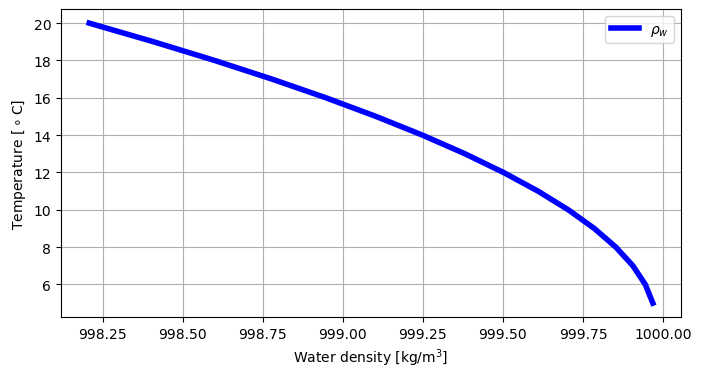

In [3]:
plt.figure(figsize=(8,4))
plt.xlabel('Water density [kg/m$^3$]')
plt.ylabel('Temperature [$^{}\circ$C]')
plt.plot(rhoWater,TC,lw=4,color='blue',label='$\\rho_w$')
plt.legend()
plt.grid()

### Stokes velocity
From the figure above, we deduce a particle density of $\rho_p \simeq 9995$ kg/m$^3$ for the central part.

We use this particle density to derive the **Stokes velocity** thoughout the vertical domain:

In [4]:
libPARTICLE.water_density(12)

999.5016478064807

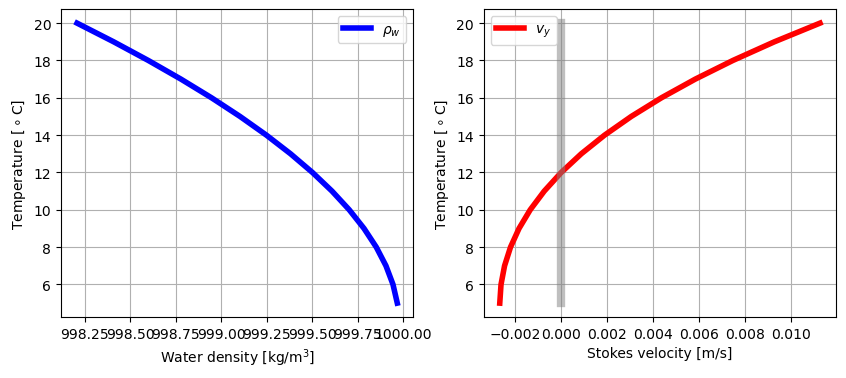

In [5]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].set_xlabel('Water density [kg/m$^3$]')
axs[0].set_ylabel('Temperature [$^{}\circ$C]')
axs[0].plot(rhoWater,TC,lw=4,color='blue',label='$\\rho_w$')
axs[0].legend()
axs[0].grid()

vy =libPARTICLE.particleVelocityStokes(r=0.002,rhoParticle=999.5,TC=TC)
axs[1].set_xlabel('Stokes velocity [m/s]')
axs[1].set_ylabel('Temperature [$^{}\circ$C]')
axs[1].plot(vy,TC,lw=4,color='red',label='$v_y$')
axs[1].plot([0,0],[TC.min(),TC.max()],lw=6,alpha=0.5,color='gray')
axs[1].legend()
axs[1].grid()

### Initial setup
We define the initial setup, a box with 1 unit side length, 1000 floating particles,
100 settled particles.

Floating particles are a cloud spread over the vertical distance along the left side.

We use the standard **materials** dictionary, but replace the **density** and the **radius** for the
floating particle at position id `1` to:
- $r=0.02$ m
- $\rho_p=999.5$ kg/m$^3$

User settings:  {'sidex': 1.0, 'sidey': 1.0, 'seedx': 0.3, 'seedy': 0.5, 'sigmax': 0.15, 'sigmay': 0.4}
{'id': 1, 'type': 'gravel', 'radius': 0.001, 'density': 2600}
{'id': 1, 'type': 'gravel', 'radius': 0.02, 'density': 999.5}


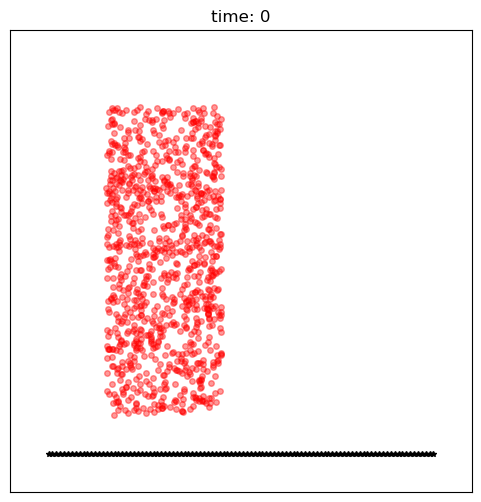

In [6]:
Nfloat=1000;Nsettled=100
sidex=1.0;sidey=1.0
seedx=0.30;seedy=0.5
sigmax=0.15;sigmay=0.4
xdiff=0.000;ydiff=0.0
xadv=0.30;yadv=True
path='div/density1';name='density1'

pX,pY,pState,pMaterial = libPARTICLE.particleInit(Nfloat=Nfloat,Nsettled=Nsettled,
                                                  sidex=sidex,sidey=sidey,seedx=seedx,seedy=seedy,
                                                  sigmax=sigmax,sigmay=sigmay)
materials = libPARTICLE.particleMaterials(show=False)
print(materials[1])
materials[1]['radius'] = 0.02
materials[1]['density'] = 999.50
print(materials[1])

libPARTICLE.particlePlot(pX,pY,pState,pMaterial,sidex=sidex,sidey=sidey,path=path,name=name,show=True)

### Run
For running this model, we need to **modify** the run function to account for the temperature-driven change in 
water density. Below, we use the vertical coordinate `pY` to scale a vertical temperature gradient:
$$
TCWater = 5 + 15 pY
$$
with $pY \in [0,1]$.

Then, water temperature is 5C along the bottom, and 15C along the top, with a linear change in between.

The water temperature is then handed down to the function `particleVelocityStokes`, where the water
density is calculated.

In [7]:
def particleRunDensity(pX,pY,pState,pMaterial,materials,tmax=10,dt=1,TC=10,**kwargs):
    """
    Particle motion
    """
    # default settings
    sidex = 1.0; sidey  = 0.5
    xdiff = 0.01; ydiff = 0.01
    path  = 'div/test1'
    name  = 'test1'
    # test for user settings
    print('User settings: ',kwargs)
    for i in kwargs:
        if (i=='sidex'): sidex = kwargs[i]
        if (i=='sidey'): sidey = kwargs[i]
        if (i=='path'): path = kwargs[i]
        if (i=='name'): name = kwargs[i]
        if (i=='xdiff'): xdiff = kwargs[i]
        if (i=='ydiff'): ydiff = kwargs[i]
        if (i=='xadv'):  xadv = kwargs[i]
        if (i=='yadv'):  yadv = kwargs[i]
        if (i=='tmax'): tmax = kwargs[i]
        if (i=='dt'): dt = kwargs[i]
        if (i=='TC'): TC = kwargs[i]
    # check for directory for plotting
    if not os.path.isdir(path):
        os.mkdir(path)
    # mean radius of all particles
    meanRadius = 0.
    for i in range(len(materials)):
        meanRadius += materials[i]['radius']
    meanRadius = meanRadius / len(materials)
    print('mean radius {} m'.format(meanRadius))
    # initialize random-number generator
    rng = np.random.default_rng(seed=12)
    t   = dt
    isaved = 1
    while (t < tmax):
        print(isaved,end=' ')
        # mark floating and settled particles in two different arrays
        pFloating = np.array([],dtype='int')
        pSettling = np.array([],dtype='int')
        # loop over particles
        for i in range(pX.shape[0]):
            if (pState[i] > 0):
                # advect particle
                radius = materials[pMaterial[i]]['radius']
                density = materials[pMaterial[i]]['density']
                TCWater    = 5. + pY[i]*15.
                pX[i] = pX[i] + libPARTICLE.particleVelocityShear(sidey-pY[i],sidey,v0=xadv,TC=TC)*dt
                if (yadv):
                    vStokes = libPARTICLE.particleVelocityStokes(radius,rhoParticle=density,TC=TCWater)
                    pY[i] = pY[i] - vStokes*dt
                # diffuse particle
                #pX[i] = pX[i] + xdiff*rng.uniform(-1,1)
                #pY[i] = pY[i] + ydiff*rng.uniform(-1,1)
                pX[i] = pX[i] + meanRadius*np.random.normal(loc=0,scale=1)
                pY[i] = pY[i] + meanRadius*np.random.normal(loc=0,scale=1)
            if (pState[i]==1): pFloating = np.append(pFloating,[i])
            if (pState[i]==0): pSettling = np.append(pSettling,[i])
        # keep fluid particles within domain
        pX = np.where(pX < 0, 0, pX)
        pX = np.where(pX > sidex, sidex, pX)
        pY = np.where(pY < 0, 0, pY)
        pY = np.where(pY > sidey, sidey, pY)
        # check, if floating particle is close to settled particle, if yes, attach
        for i,ip in enumerate(pFloating):
            for j,ic in enumerate(pSettling):
                dist = materials[pMaterial[ip]]['radius'] + materials[pMaterial[ic]]['radius']
                #dist = 0.01
                if (np.sqrt((pX[ip]-pX[ic])**2 + (pY[ip]-pY[ic])**2) < 2*dist):
                    ##print(i,ip,j,ic)
                    pState[ip] = 0
        # plot particle locations to file
        libPARTICLE.particlePlot(pX,pY,pState,pMaterial,time=t,isaved=isaved,sidex=sidex,sidey=sidey,path=path,name=name)
        t      += dt
        isaved += 1
    return

In [8]:
particleRunDensity(pX,pY,pState,pMaterial,materials,tmax=1.5,dt=0.01,
                        sidex=sidex,sidey=sidey,xdiff=xdiff,ydiff=ydiff,
                        xadv=xadv,yadv=yadv,path=path,name=name)

User settings:  {'sidex': 1.0, 'sidey': 1.0, 'xdiff': 0.0, 'ydiff': 0.0, 'xadv': 0.3, 'yadv': True, 'path': 'div/density1', 'name': 'density1'}
mean radius 0.0053750000000000004 m
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

----